# Functional connectivity : raw analysis

This notebook demonstrates the analysis steps used to generate the fluorescence traces from the raw movies. Briefly, the script :
- reads the data and metadata from Prairie microscopy files corresponding to a given fly
- corrects movement drifts between successive runs
- detects regions of interests
- compute the fluorescence traces and convert them to &#916;F/F<sub>0</sub> (with a global F<sub>0</sub>) for the all experiment.


For production analysis, we used the script `functionalConnectivityRaw.jl` (in the `code` folder), which loops those steps for all the experiments, from the command line, as : 
```bash
julia -p X functionalConnectivityRaw.jl pathToData
```
 from the `CX-Functional-Analysis folder`, where X is the number of processes we used (some steps of the analysis benefit from parallelization). This requires to have downloaded and unzipped the data locally (in the `pathToData` folder).

### Preparing the environment

#### Define some variables, set working directory

In [1]:
cd("..")                             ## We run everything from the CX-Functional-Analysis folder

In [63]:
tablePath = "labbookTable.csv"       ## Path to the labbook table
linesTable = "LinesAndTypes.csv"
baseDataFolder = "example-raw-data"  ## Where we will store the data

"example-raw-data2"

In [62]:
`archivemount example-raw-data /feb1916.zip example-raw-data2`

`archivemount example-raw-data2/feb1916.zip example-raw-data2`

#### Loading packages and convenience functions

In [9]:
using DataFrames,CSV                 
using Images
using FileIO,ImageMagick
using subpixelRegistration
using FluorescentSeries             
using PrairieIO                     
using Clustering   

include("code/functions/PrairieLabbook.jl")
include("code/functions/imageUtilities.jl")

kMeansIm (generic function with 1 method)

#### Note on example data

The github repository this notebook comes from contains a small example data folder we're using here. If you're running this notebook locally (as opposed as from Binder), you can download the full dataset from the OpenScienceFramework [repository](https://osf.io/vsa3z/) associated with the paper.

### Load the labbook, pick fly to analyze

#### linesToType contains the table listing information on the drivers

In [4]:
linesToType = CSV.read(linesTable)

,Line,Wolff Type Name,New Type Name,Type Description,Supertype,Pre regions,Post regions,Pre regions fine,Post regions fine
1,87G07,4,P-F3N2d,PBG2-9.s-FBl3.b-NO2D.b,FB columnar,"FB,NO","PB,NO","FB3,NO2","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,NO2"
2,85H06,1-2,P-F1N3,PBG2-9.s-FBl1.b-NO3PM.b,FB columnar,"FB,NO","PB,NO","FB1,NO3","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,NO3"
3,60D05,8,E-PG,PBG1-8.b-EBw.s-DV_GA.b,EB columnar,"PB,GA",EB,"PB1,PB2,PB3,PB4,PB5,PB6,PB7,PB8,GA",EB
4,SS02191,7,P-EG,PBG1-8.s-EBt.b-DV_GA.b,EB columnar,"GA,EB","PB,EB","GA,EB","PB1,PB2,PB3,PB4,PB5,PB6,PB7,PB8,EB"
5,67D09,5,P-F3N2v,PBG2-9.s-FBl3.b-NO2V.b,FB columnar,"FB,NO","PB,NO","FB3,NO2","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,NO2"
6,67D09-attP5,5,P-F3N2v,PBG2-9.s-FBl3.b-NO2V.b,FB columnar,"FB,NO","PB,NO","FB3,NO2","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,NO2"
7,67D09-VK22,5,P-F3N2v,PBG2-9.s-FBl3.b-NO2V.b,FB columnar,"FB,NO","PB,NO","FB3,NO2","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,NO2"
8,37F06,6,P-EN1,PBG2-9.s-EBt.b-NO1.b.Type1,EB columnar,"EB,NO","PB,EB,NO","EB,NO1","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,EB,NO1"
9,37F06-VK22,6,P-EN1,PBG2-9.s-EBt.b-NO1.b.Type1,EB columnar,"EB,NO","PB,EB,NO","EB,NO1","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,EB,NO1"
10,VT008135,6,P-EN1,PBG2-9.s-EBt.b-NO1.b.Type1,EB columnar,"EB,NO","PB,EB,NO","EB,NO1","PB2,PB3,PB4,PB5,PB6,PB7,PB8,PB9,EB,NO1"


#### Labbook
The labbook is stored as a ```csv``` file. ```readLabbook``` (defined in ```functions\PrairieLabbook.jl```) reads that file reformats it and adds some information to it. It also select the lines corresponding to a set of experiments (defined as ```expDay```) a returns the subset of the full labbook corresponding to those in ```subTab```.

In [5]:
(mainTab,subTab) = readLabbook(tablePath,linesToType,expDay=["feb1916"]);
subTab

,ITEM,Sex,ActivatorExp,ReporterExp,LexA,Gal4,ReporterSite,ActivatorSite,Days,Runs,Stack,Drug,DrugTime,DrugConc,DrugRuns,TAGS,TIMESTAMP,folderName,Region,RegionRuns,genotype,genotypeRegion,genotypePre,genotypePost,driverPre,driverPost,cellPre,cellPost,cellToCell,flyN,keyEntry
1,*** 60D05 Chrimson - 55G08L GCamp6m,Female,Gal4,LexA,55G08,60D05,attP1,VK5,7,"[13, 14, 15, 16, 17, 18]",3,missing,missing,missing,missing,missing,2016-02-19,feb1916,PB-in,13:18,55G08LexA-60D05Gal4-Chrimson-in-Gal4,55G08LexA-60D05Gal4-Chrimson-in-Gal4-PB-in,60D05Gal4,55G08LexA,60D05,55G08,PBG1-8.b-EBw.s-DV_GA.b,PB18.s-GxΔ7Gy.b-PB18.s-9i1i8c.b,PBG1-8.b-EBw.s-DV_GA.b-to-PB18.s-GxΔ7Gy.b-PB18.s-9i1i8c.b,1,feb1916-Fly1-PB-in
2,*** 84H05L Chrimson - 72H06 GCamp6m,Female,LexA,Gal4,84H05,72H06,attP1,VK5,7,"[7, 8, 9, 10, 11, 12]",2,missing,missing,missing,missing,missing,2016-02-19,feb1916,LAL,7:12,84H05LexA-72H06Gal4-Chrimson-in-LexA,84H05LexA-72H06Gal4-Chrimson-in-LexA-LAL,84H05LexA,72H06Gal4,84H05,72H06,PBG1-7.s-FBl2.s-LAL.b-cre.b,SMP.s-LAL.s-LAL.b.contra,PBG1-7.s-FBl2.s-LAL.b-cre.b-to-SMP.s-LAL.s-LAL.b.contra,2,feb1916-Fly2-LAL
3,*** 84H05L Chrimson - 72H06 GCamp6m,Female,LexA,Gal4,84H05,72H06,attP1,VK5,7,"[1, 2, 3, 4, 5, 6]",1,missing,missing,missing,missing,missing,2016-02-19,feb1916,LAL,1:6,84H05LexA-72H06Gal4-Chrimson-in-LexA,84H05LexA-72H06Gal4-Chrimson-in-LexA-LAL,84H05LexA,72H06Gal4,84H05,72H06,PBG1-7.s-FBl2.s-LAL.b-cre.b,SMP.s-LAL.s-LAL.b.contra,PBG1-7.s-FBl2.s-LAL.b-cre.b-to-SMP.s-LAL.s-LAL.b.contra,3,feb1916-Fly3-LAL


#### Prairie file metadata
We select the one line of the labbook that is present in the github repo. After that, function ```makeFlyDict``` extracts relevant metadata from the corresponding files in an array of dictionaries. The experiment we selected has six runs, so it's a six element array. We show the first element below.

In [40]:
exampleTab = subTab[subTab[:Runs] .== (collect(1:6),),:] ## Selecting the line that corresponds to the example
fly = makeflyDict(exampleTab,dataFolder=baseDataFolder)
fly[1]

Dict{String,Any} with 7 entries:
  "laser"        => Dict("laser.1"=>Dict{AbstractString,AbstractString}(Pair{Ab…
  "sequences"    => Dict{String,Any}[Dict{String,Any}(Pair{String,Any}("attribu…
  "frames"       => Dict[Dict{String,Any}(Pair{String,Any}("timing", [0.571, 0.…
  "DAC"          => Array{Dict{String,Dict{String,Any}},1}[Dict{String,Dict{Str…
  "globalConfig" => Dict{String,Any}(Pair{String,Any}("zDevice", 0),Pair{String…
  "dataDir"      => "example-raw-data/feb1916/TSeries-02192016-001"
  "version"      => "5.0.32.49"

#### Read the movies into Julia
We loop (using the ```map``` function) on the metadata array to extract the fluorescence from the corresponding image files (this information is in the "frames" field of each dictionary). It returns and array (again of 6 elements) of dictionaries. 

In [64]:
 runFluos = map(fly) do run
        gc()
        roiDict = runExtract(run,mvtCorrect=false)
    end
runFluos[1]

Dict{String,Any} with 8 entries:
  "B"             => 0.00162484
  "pulseNumber"   => 30
  "av"            => Float32[0.00188887 0.00149907 … 0.00161103 0.00151197; 0.0…
  "green"         => AxisArrays.AxisArray{FixedPointNumbers.Normed{UInt16,12},3…
  "runStart"      => 0001-01-01T11:12:42
  "runAv"         => Float32[0.000976801 0.000915751 … 0.0137363 0.00140415; 0.…
  "runStop"       => 0001-01-01T11:13:53
  "stimIntensity" => 1

```B``` is the computed background for those movies (the average intensity of the 10% dimmest pixels). ```pulseNumber``` and ```stimIntensity``` correspond to the stimulation protocol. Movies are stored in ```green``` (raw data), ```runAv``` (average per repeat, each movie contains four repeats), and ```av``` (average of the repeat averages). If we take a look at the ```green``` field, we see it's a four element array (one per repeat), and each of those elements is a Julia ```AxisArray```, a convenient format to represent images (see https://juliaimages.github.io/latest/):

In [46]:
runFluos[1]["green"][1]

3-dimensional AxisArray{N4f12,3,...} with axes:
    :x, 0.0951465006645495:0.190293001329099:15.508879608321568
    :y, 0.0951434879605955:0.190286975921191:28.828476852060437
    :time, 0.0:0.0622697153999659:16.439204865590998
And data, a 82×152×265 Array{N4f12,3}:
[:, :, 1] =
 0.001N4f12   0.001N4f12   0.001N4f12   …  0.001N4f12   0.0012N4f12
 0.001N4f12   0.001N4f12   0.001N4f12      0.001N4f12   0.001N4f12 
 0.001N4f12   0.001N4f12   0.0007N4f12     0.001N4f12   0.0007N4f12
 0.0012N4f12  0.001N4f12   0.001N4f12      0.001N4f12   0.0012N4f12
 0.001N4f12   0.001N4f12   0.001N4f12      0.001N4f12   0.001N4f12 
 0.001N4f12   0.001N4f12   0.001N4f12   …  0.001N4f12   0.001N4f12 
 0.001N4f12   0.001N4f12   0.001N4f12      0.001N4f12   0.001N4f12 
 0.0012N4f12  0.001N4f12   0.001N4f12      0.001N4f12   0.001N4f12 
 0.001N4f12   0.001N4f12   0.001N4f12      0.001N4f12   0.001N4f12 
 0.0012N4f12  0.001N4f12   0.001N4f12      0.0012N4f12  0.001N4f12 
 0.001N4f12   0.001N4f12   0.001N4f12   

#### Drift correction
Using the average images, we correct for possible drifts in successive experiments and crop the results to a common area.

In [57]:
drugStart = Missings.missing
shifts = SharedArray{Int64}(2,length(runFluos)-1)
ref = convert(SharedArray,runFluos[length(runFluos)]["av"])

runFluos[1:(length(runFluos)-1)] = pmap(runFluos[1:(length(runFluos)-1)],1:(length(runFluos)-1)) do rF,run
    registration = subpixelRegistration.stackDftReg(rF["av"],ref=ref,ufac=1)
    shifts[:,run] = round.(Int64,registration["shift"])
    ## Align the grand averages
    rF["av"] = subpixelRegistration.alignFromDict(rF["av"],registration)
    ## Align the run averages (those are "volumes" so we need to set the z shift to 0)
    registration["shift"] = [registration["shift"];0]
    rF["runAv"] = subpixelRegistration.alignFromDict(rF["runAv"],registration)
    ## Finally align the individual runs
    for rep in 1:length(rF["green"])
        rF["green"][rep][:,:,:] = subpixelRegistration.alignFromDict(rF["green"][rep],registration)
    end
    rF
end
maxShiftPos = round.(Int64,maximum([[0;0] shifts],2))
maxShiftNeg = round.(Int64,minimum([[0;0] shifts],2))
    
## Cropping everything to the area common to all repeats // catch time to drug
cropRegion = [(1+maxShiftPos[i]):(size(runFluos[1]["av"])[i]+maxShiftNeg[i]) for i in 1:2]
for run in 1:length(runFluos)
    runFluos[run]["av"] = runFluos[run]["av"][cropRegion...]
    runFluos[run]["runAv"] = runFluos[run]["runAv"][cropRegion...,:]
    for rep in 1:length(runFluos[run]["green"])
        runFluos[run]["green"][rep] = runFluos[run]["green"][rep][cropRegion...,:]
    end
    if !ismissing(drugStart)
        runFluos[run]["timeToDrug"] = drugStart - runFluos[run]["runStart"]
    else
        runFluos[run]["timeToDrug"] = Missings.missing
    end
end

#### Region of interest detection
The ROI detection is done on the average of all the movies in the experiment :

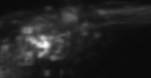

In [52]:
grdAv = mapreduce(x -> x["av"],+,runFluos)/length(runFluos)
Gray.(scaleminmax(0,maximum(grdAv)).(grdAv))

ROIs are calculated with a simple k-means clustering on the pixel intensities (the function ```kMeansIm``` is defined in ```functions\imageUtilities.jl``` : besides performing clustering it just reorders the clusters so that the "dark" one is assigned 0 and the bright one 1).

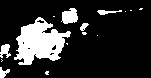

In [53]:
fluorescentRegions = kMeansIm(grdAv,2)
Gray.(fluorescentRegions)

#### Fluorescence extraction
We first extract the fluorescence parameters (as a dictionary) and the fluorescence traces (as an array of AxisArrays) : 

In [58]:
fluoSimple = [cat(3,[FluorescentSerie(rep,fluorescentRegions) for rep in runF["green"]]...) for runF in runFluos]
fluoParams = [Dict("pulseNumber" => runF["pulseNumber"],
                   "timeToDrug" => runF["timeToDrug"],
                   "stimIntensity"=>runF["stimIntensity"]) for runF in runFluos]
fluoSimple[1]

3-dimensional AxisArray{Float64,3,...} with axes:
    :time, 0.0:0.0622697153999659:16.439204865590998
    :ROI, 1:1
    :page, Base.OneTo(4)
And data, a 265×1×4 Array{Float64,3}:
[:, :, 1] =
 22.1961
 22.5438
 21.7519
 20.3543
 22.2515
 20.4947
 23.7072
 20.5487
 21.4701
 22.105 
 21.2159
 21.3482
 21.1326
  ⋮     
 21.4115
 23.1748
 22.4672
 23.2449
 20.631 
 22.1267
 21.3463
 22.8193
 23.5219
 21.4974
 19.959 
 22.0796

[:, :, 2] =
 22.5255
 23.9875
 25.8347
 22.9346
 23.2291
 22.9416
 22.8647
 23.537 
 22.3932
 20.7805
 23.1284
 24.4982
 22.0139
  ⋮     
 21.409 
 22.2545
 22.2589
 24.3944
 23.6532
 24.4427
 23.1795
 23.8947
 23.8982
 22.6015
 22.9175
 21.2901

[:, :, 3] =
 25.1678
 23.3031
 23.9492
 25.5536
 23.8193
 21.8173
 23.6618
 22.4156
 23.9338
 22.4825
 25.2049
 23.6024
 21.9011
  ⋮     
 24.5724
 22.959 
 23.2637
 22.7709
 22.8208
 26.3143
 21.8051
 23.9768
 22.7407
 23.0945
 22.9712
 23.738 

[:, :, 4] =
 26.4847
 25.0078
 25.1788
 24.9629
 24.3934
 24.8803
 24.0132
 22.

Each one of this AxisArrays has three axis : ```:time```, ```:ROI``` (which should be self explanatory) and ```page``` which corresponds to the experimental repeats.

#### &#916;F/F<sub>0</sub> calculation
We first extract the Pockels cell configuration so that we only group runs with the same setting for &#916;F/F<sub>0</sub> calculation. In this case there's only one level so all runs will be grouped.

In [59]:
## Find the global F0 as the median of the 5% dimmest pixels
pockelsParams = [fly[i]["globalConfig"]["laserPower_0"] for i in eachindex(fly)]
powerLevels = unique(pockelsParams)

1-element Array{Int64,1}:
 12

The global F<sub>0</sub> is then defined as the median fluorescence in the 5% dimmest frames in the ROI. The ```deltaFF``` function (defined in the [FluorescentSeries package](https://github.com/romainFr/FluorescentSeries.jl) computes the &#916;F/F<sub>0</sub>.

In [35]:
## Initialize with the raw fluo
deltaFluoSimple = fluoSimple
## The background used is the mean background
globalBackground = mean([run["B"] for run in runFluos])
## Empty array of baselines
globalBaseline = Array{Array{Float64,1}}(length(powerLevels))
## Looping over the Pockels setting groups
for pw in eachindex(powerLevels)
    runsIdx = find(pockelsParams .== powerLevels[pw])
    length(runsIdx) == 1 ? giantFluo = fluoSimple[runsIdx[1]] : giantFluo = vcat([x.data for x in fluoSimple[runsIdx]]...)
        
    giantFluo = reshape(permutedims(giantFluo,[1;3;2]),size(giantFluo,1)*size(giantFluo,3),size(giantFluo,2))
    globalQ3 = [quantile(giantFluo[:,i],0.05) for i in 1:size(giantFluo)[2]]
    globalBaseline = median(giantFluo[find(giantFluo.< transpose(globalQ3))],1)[:]
    deltaFluoSimple[runsIdx] = [deltaFF(fluoSimple[runsIdx][i],
                                        globalBaseline,
                                        globalBackground) for i in eachindex(fluoSimple[runsIdx])]
end

#### Image formating for export
We just give the images meaningful axis for export.

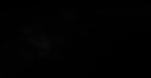

In [60]:
grdAv = AxisArray(Gray.(N4f12.(grdAv)),axes(runFluos[1]["green"][1],1),axes(runFluos[1]["green"][1],2))

In [61]:
fluorescentRegions = AxisArray(fluorescentRegions,axes(runFluos[1]["green"][1],1),axes(runFluos[1]["green"][1],2))

2-dimensional AxisArray{Int64,2,...} with axes:
    :x, 0.0951465006645495:0.190293001329099:14.747707603005171
    :y, 0.2854304638817865:0.190286975921191:28.828476852060437
And data, a 78×151 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  1  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  0  0  0  0  0  0  0  0  0
 0  0  0 

## Not run (runs in the script)

The production script runs those functions in a loop, stores each deltaFluoSimple/fluoParams as an entry in a dictionnary (save in the rawData.jld2 file), the average image and the ROI image in expImages.jld2, and the data frame version of the labbook in labbookTable.jld2